This is a small example of using the MNIST dataset in its original form. It demonstrates how to write a custom transform class to be consumed by FastAI. For training we use a pre-trained resnet model and just fine tune the last layer. This notebook will install the necessary packages via pip and download the MNIST dataset. 

# Table of Contents
1. [Installation](#installation)
2. [Load the MNIST data](#load)
3. [Visualize some the data](#viz)
4. [Custom Transform](#transform)
5. [Setup Dataloaders](#dataloaders)
6. [Train the model](#train)
7. [Evaluate the model on the test set](#test_eval)
8. [Visualize misclassification](#viz_miss)

# Installation <a name="installation"></a>
You can skip this if you already have these packages.

In [ ]:
import sys

!{sys.executable} -m pip install fastai
!{sys.executable} -m pip install gzip
!{sys.executable} -m pip install wget

# Load the MNIST data <a name="load"></a>
This will download the MNIST data if you don't have it already.

In [9]:
from fastai.vision.all import *
from PIL import Image
from matplotlib.pyplot import imshow
import numpy as np
import sys
import numpy as np
import gzip
import wget
import os

# if you use a dark theme for Jupyter
plt.style.use('dark_background')

# http://yann.lecun.com/exdb/mnist/
def read_mnist_image(file):
    with gzip.open(file, 'r') as f:
        f.read(4) # magic number
        num_images = int.from_bytes(f.read(4), byteorder='big')
        image_height = int.from_bytes(f.read(4), byteorder='big')
        image_width = int.from_bytes(f.read(4), byteorder='big')

        buf = f.read(image_width * image_height * num_images)
        data = np.frombuffer(buf, dtype=np.uint8)
        data = data.reshape(num_images, image_height, image_width)
        data = data.astype(dtype=np.float32) / 255.0 # normalize to [0,1]
        
        return data
    
def read_mnist_label(file):
    with gzip.open(file, 'r') as f:
        f.read(4) # magic number
        num_labels = int.from_bytes(f.read(4), byteorder='big')
        buf = f.read(num_labels)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.int32)

        return data
    
# download dataset if it doesn't exist    
files = ['train-images-idx3-ubyte.gz', 
         'train-labels-idx1-ubyte.gz', 
         't10k-images-idx3-ubyte.gz', 
         't10k-labels-idx1-ubyte.gz']

def bar_progress(current, total, width=80):
  progress_message = f"Downloading: {current*100.0/total:.2f}%% [{current} / {total}] bytes"
  # Don't use print() as it will print in new line every time.
  sys.stdout.write("\r" + progress_message)
  sys.stdout.flush()
    
for f in files:
    if not os.path.exists(f):        
        url = 'http://yann.lecun.com/exdb/mnist/' + f
        print(url)
        wget.download(url, bar=bar_progress)  
        print("")
        
train_image = read_mnist_image('train-images-idx3-ubyte.gz')
train_label = read_mnist_label('train-labels-idx1-ubyte.gz')
test_image = read_mnist_image('t10k-images-idx3-ubyte.gz')
test_label = read_mnist_label('t10k-labels-idx1-ubyte.gz')

print("")
print("train_image:", train_image.shape)
print("train_label:", train_label.shape)
print("test_image:", test_image.shape)
print("test_label:", test_label.shape)


train_image: (60000, 28, 28)
train_label: (60000,)
test_image: (10000, 28, 28)
test_label: (10000,)


# Visualize some of the data <a name="viz">
This is a sanity check to make sure we loaded the images correctly.

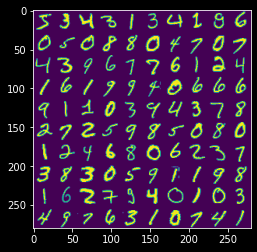

In [11]:
nrows = 10
ncols = 10

_, h, w = train_image.shape
canvas = Image.new('F', (ncols*w, nrows*h))

idx = 0
for i in range(nrows):
    for j in range(ncols):
        image = Image.fromarray(train_image[idx])
        canvas.paste(image, (i*h, j*w))
        idx += 1
        
imshow(np.asarray(canvas));

# Custom Transform <a name="transform">
Based on information from https://docs.fast.ai/tutorial.siamese.html

In [14]:
class NumpyImage(fastuple):
    def show(self, ctx=None, **kwargs): 
        img, label = self
        return show_image(img, title=label, ctx=ctx, **kwargs)
    
class NumpyTransform(Transform):
    def __init__(self, data, label):
        self.data, self.label = data, label
    
    def encodes(self, i):
        # to use off the shelf CNN network eg. Resnet
        # this needs to return a 3x28x28 tensor (RGB)
        # we'll duplicate the gray channel 3 times   
        img = self.data[i]
        img = np.array([img, img, img])
        
        return NumpyImage(img, self.label[i])

@typedispatch
def show_batch(
    x: NumpyImage, y, samples, 
    ctxs = None, max_n = 9, 
    nrows = None, ncols = 3, 
    figsize = None, **kwargs):
    
    if figsize is None: 
        figsize = (10, 10)
        
    if ctxs is None: 
        ctxs = get_grid(
            min(x[0].shape[0], max_n), 
            nrows = None, ncols = ncols, 
            figsize = figsize)
        
    for i, ctx in enumerate(ctxs): 
        NumpyImage(x[0][i], x[1][i]).show(ctx=ctx)

# Setup dataloaders <a name="dataloaders">

In [15]:
# make train/validation set
total_len = train_image.shape[0]
idxs = np.random.permutation(range(total_len))
cut = int(0.8 * total_len)
           
idx1 = idxs[:cut]
idx2 = idxs[cut:]

train_tl = TfmdLists(range(len(idx1)), NumpyTransform(train_image, train_label))
valid_tl = TfmdLists(range(len(idx2)), NumpyTransform(train_image, train_label))

dls = DataLoaders.from_dsets(train_tl, valid_tl)

# Train model <a name="train">
Train using xreset18 model and save out the model. By default it saves out to models/[name].pth

In [18]:
model = xresnet18(n_out=10)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(5)
learn.save("mnist_model")

epoch,train_loss,valid_loss,accuracy,time
0,0.091408,0.093971,0.970667,06:22
1,0.059656,0.059345,0.982250,06:11
2,0.033832,0.017699,0.995000,05:42
3,0.012122,0.004133,0.998833,05:39
4,0.007449,0.002577,0.999583,05:40


Path('models/mnist_model.pth')

# Evaluate model on test set <a name="eval_test">
Load the saved model and perform inference on the test set. I've duplicated some code to demonstrate how to load the model at a later time. It requires instantiating the Learner with the same parameters used during training. Maybe I should use learner.export? 

In [24]:
model = xresnet18(n_out=10)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn = learn.load("mnist_model")
test_tl = TfmdLists(range(test_image.shape[0]), NumpyTransform(test_image, test_label))
dl = learn.dls.test_dl(test_tl)
pred = learn.get_preds(dl=dl)

accuracy(pred[0], torch.from_numpy(test_label)).item()

0.9940000176429749

# Visualize misclassification <a name="viz_miss">
Visualize some of the incorrectly classified images. The top of each image shows the results as [predicted|ground truth]. Even a human would have trouble recognizing some of these numbers!

incorrect classfication: 60


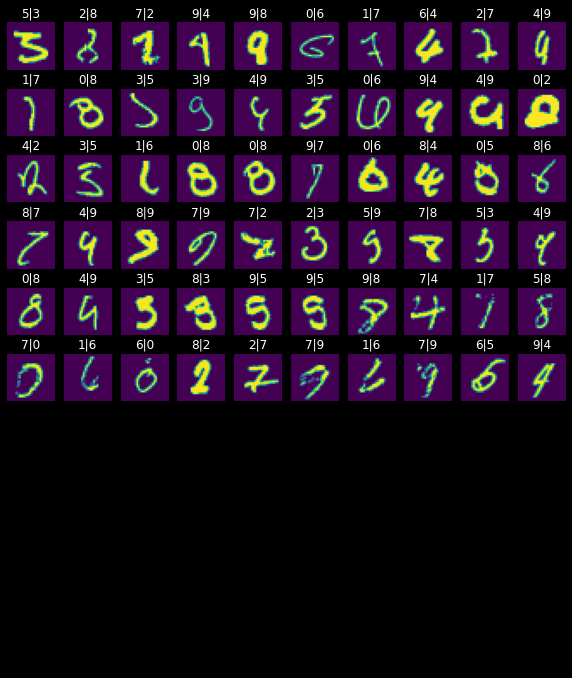

In [32]:
pred_label = pred[0].argmax(dim=1) 
wrong_idx = torch.nonzero(pred_label != torch.from_numpy(test_label))
print(f"incorrect classfication: {wrong_idx.shape[0]}")

ctxs = get_grid(min(wrong_idx.shape[0], 100), nrows=10, ncols=10, figsize=(10,12))

for i, ctx in enumerate(ctxs): 
    idx = wrong_idx[i]
    NumpyImage(test_image[idx], f"{pred_label[idx].item()}|{test_label[idx]}").show(ctx=ctx)